<a href="https://colab.research.google.com/github/malikalnser/stackoverflow-tags-predict-scikitlearn/blob/main/stackoverflow_tags_predict_scikitlearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    ! wget https://raw.githubusercontent.com/hse-aml/natural-language-processing/master/setup_google_colab.py -O setup_google_colab.py
    import setup_google_colab
    setup_google_colab.setup_week1() 
    
import sys
sys.path.append("..")
from common.download_utils import download_week1_resources

download_week1_resources()

--2021-06-25 23:37:59--  https://raw.githubusercontent.com/hse-aml/natural-language-processing/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1939 (1.9K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   1.89K  --.-KB/s    in 0s      

2021-06-25 23:37:59 (24.9 MB/s) - ‘setup_google_colab.py’ saved [1939/1939]



In [2]:
from grader import Grader
grader = Grader()

In [3]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
from ast import literal_eval
import pandas as pd
import numpy as np

In [5]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

In [6]:
train = read_data('data/train.tsv')
validation = read_data('data/validation.tsv')
test = pd.read_csv('data/test.tsv', sep='\t')

In [7]:
train.head()

,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]


In [8]:
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

In [9]:
import re

In [10]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
  text = text.lower() # lowercase text
  text = REPLACE_BY_SPACE_RE.sub('', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
  text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
  text = " ".join(word for word in text.split() if word not in STOPWORDS)
  #text = re.compile(r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*').sub('', text)
  #text = re.sub(STOPWORDS, '', text) # delete stopwords from text
  return text

In [11]:
def test_text_prepare():
  examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
              "How to free c++ memory vector<int> * arr?"]
  answers = ["sql server equivalent excels choose function", 
              "free c++ memory vectorint arr"]
  for ex, ans in zip(examples, answers):
      if text_prepare(ex) != ans:
          return "Wrong answer for the case: '%s'" % ex, text_prepare(ex)
  return 'Basic tests are passed.'

In [12]:
print(test_text_prepare())

Basic tests are passed.


In [13]:
prepared_questions = []
for line in open('data/text_prepare_tests.tsv', encoding='utf-8'):
    line = text_prepare(line.strip())
    prepared_questions.append(line)
text_prepare_results = '\n'.join(prepared_questions)

grader.submit_tag('TextPrepare', text_prepare_results)

Current answer for task TextPrepare is:
 sqlitephp readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date ...


In [14]:
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

In [15]:
X_train[:3]

['draw stacked dotplot r',
 'mysql select records datetime field less specified value',
 'terminate windows phone 81 app']

In [16]:
# Dictionary of all tags from train corpus with their counts.
tags_counts = {}
for tags in y_train:
  for tag in tags:
    if tag not in tags_counts:
      tags_counts[tag] = 1
    else:
      tags_counts[tag] += 1
# Dictionary of all words from train corpus with their counts.
words_counts = {}
for words in X_train:
  for word in words.split():
    #print(word, 'wooooooooord')
    if word not in words_counts:
      words_counts[word] = 1
    else:
      words_counts[word] += 1

######################################
######### YOUR CODE HERE #############
######################################
# print(tags_counts)
# print(words_counts)

In [17]:
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]

grader.submit_tag('WordsTagsCount', '%s\n%s' % (','.join(tag for tag, _ in most_common_tags), 
                                                ','.join(word for word, _ in most_common_words)))

Current answer for task WordsTagsCount is:
 javascript,c#,java
using,php,java...


In [18]:
DICT_SIZE = 5000
INDEX_TO_WORDS  = sorted(words_counts.keys(), key = lambda x: words_counts[x], reverse = True)[:DICT_SIZE]
WORDS_TO_INDEX = {word: i for i, word in enumerate(INDEX_TO_WORDS)}
ALL_WORDS = WORDS_TO_INDEX.keys()

def my_bag_of_words(text, words_to_index, dict_size):
    result_vector = np.zeros(dict_size)
    for word in text.split():
      if word in words_to_index:
        result_vector[words_to_index[word]] =+ 1
        # result_vector[words_to_index[word]] = 1
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """


    return result_vector

In [19]:
def test_my_bag_of_words():
    words_to_index = {'hi': 0, 'you': 1, 'me': 2, 'are': 3}
    examples = ['hi how are you']
    answers = [[1, 1, 0, 1]]
    for ex, ans in zip(examples, answers):
        if (my_bag_of_words(ex, words_to_index, 4) != ans).any():
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [20]:
print(test_my_bag_of_words())

Basic tests are passed.


In [21]:
from scipy import sparse as sp_sparse

In [22]:
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (100000, 5000)
X_val shape  (30000, 5000)
X_test shape  (20000, 5000)


In [23]:
row = X_train_mybag[10].toarray()[0]
print(row)
non_zero_elements_count = (row > 0).sum()
print(non_zero_elements_count)

#grader.submit_tag('BagOfWords', str(non_zero_elements_count))

[0. 0. 0. ... 0. 0. 0.]
7


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [25]:
def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
    
    
    tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.9, ngram_range=(1,2), token_pattern='(\S+)')

    X_train = tfidf_vectorizer.fit_transform(X_train)
    X_val = tfidf_vectorizer.transform(X_val)
    X_test = tfidf_vectorizer.transform(X_test) 
    
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_

In [26]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [27]:
print(tfidf_vocab['c++'], tfidf_vocab['c#'])

1935 1839


In [28]:
from sklearn.preprocessing import MultiLabelBinarizer

In [29]:
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

In [30]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [31]:
def train_classifier(X_train, y_train):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """


    clf = OneVsRestClassifier(LogisticRegression(multi_class='ovr', max_iter = 200, penalty='l1', solver='liblinear', C=1.0))
    # BEST: BoW: 0.653 tf-idf: 0.648

    # clf = OneVsRestClassifier(LogisticRegression(multi_class='ovr', max_iter = 200))
    # DEFAULT: 0.645 0.608

    # clf = OneVsRestClassifier(LogisticRegression(multi_class='ovr', max_iter = 200, C=0.1))
    # WORST: 0.585 0.384
    
    # clf = OneVsRestClassifier(LogisticRegression(multi_class='ovr', max_iter = 200, penalty='l1', solver='liblinear', C=0.1))
    # 0.608 0.559

    # clf = OneVsRestClassifier(LogisticRegression(multi_class='ovr', max_iter = 200, penalty='l1', solver='liblinear', C=10.0))
    # 0.644 0.643

    # clf = OneVsRestClassifier(LogisticRegression(multi_class='ovr', max_iter = 200, penalty='l1', solver='liblinear', C=100.0))
    # 0.615 0.583

    # clf = OneVsRestClassifier(LogisticRegression(multi_class='multinomial', max_iter = 200, penalty='l2', solver='lbfgs', C=1.0), n_jobs=2)
    # 0.650 0.631

    clf.fit(X_train,y_train)
    return clf
    # Create and fit LogisticRegression wraped into OneVsRestClassifier.

    ######################################
    ######### YOUR CODE HERE #############
    ######################################


In [32]:
classifier_mybag = train_classifier(X_train_mybag, y_train)
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

In [33]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

In [34]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_mybag)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(3):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	class


Title:	contenttype applicationjson required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	ruby-on-rails




In [35]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [36]:
def print_evaluation_scores(y_val, predicted):
    
    ######################################
    ######### YOUR CODE HERE #############
    ######################################

    accuracy = accuracy_score(y_val, predicted)
    F1ma = f1_score(y_val, predicted, average='macro')
    F1mi = f1_score(y_val, predicted, average='micro')
    F1we = f1_score(y_val, predicted, average='weighted')
    Percisionma = average_precision_score(y_val, predicted, average='macro')
    Percisionmi = average_precision_score(y_val, predicted, average='micro')
    Percisionwe = average_precision_score(y_val, predicted, average='weighted')
    print('accuracy {}\n F1 macro {}\n F1 micro {}\n F1 weighted {}\n percision macro {}\n percision micro {}\n percision weighted {}\n'.format(
        accuracy, F1ma, F1mi, F1we, Percisionma, Percisionmi, Percisionwe))

In [37]:
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words
accuracy 0.3631666666666667
 F1 macro 0.5139865519487116
 F1 micro 0.6752796108684201
 F1 weighted 0.6532874326644985
 percision macro 0.3525482522638131
 percision micro 0.48533171360855437
 percision weighted 0.5149512903000888

Tfidf
accuracy 0.3617666666666667
 F1 macro 0.5054031613102365
 F1 micro 0.6705046212462187
 F1 weighted 0.6480841142551851
 percision macro 0.34556907051015784
 percision micro 0.482346790398833
 percision weighted 0.5120738756482641



In [38]:
from metrics import roc_auc
%matplotlib inline

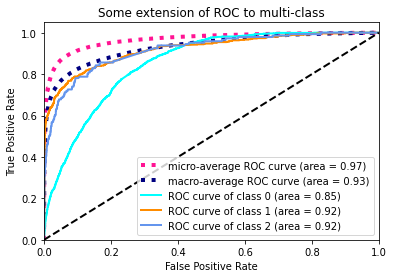

In [39]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_mybag, n_classes)

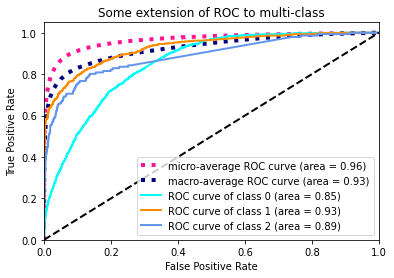

In [40]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)

In [41]:
# this is where I should compare BoW vs tf-idf....I was more happy with tf-idf

In [42]:
test_predictions = classifier_tfidf.predict(X_test_tfidf) ######### YOUR CODE HERE #############
test_pred_inversed = mlb.inverse_transform(test_predictions)

test_predictions_for_submission = '\n'.join('%i\t%s' % (i, ','.join(row)) for i, row in enumerate(test_pred_inversed))
grader.submit_tag('MultilabelClassification', test_predictions_for_submission)

Current answer for task MultilabelClassification is:
 0	mysql,php
1	javascript
2	
3	javascript,jquery
4	android,java
5	php,xml
6	json
7	java,swing
8	pytho...


In [43]:
test_predictions = classifier_mybag.predict(X_test_mybag) ######### YOUR CODE HERE #############
test_pred_inversed = mlb.inverse_transform(test_predictions)

test_predictions_for_submission = '\n'.join('%i\t%s' % (i, ','.join(row)) for i, row in enumerate(test_pred_inversed))
grader.submit_tag('MultilabelClassification', test_predictions_for_submission)

Current answer for task MultilabelClassification is:
 0	mysql,php
1	javascript
2	
3	javascript,jquery
4	android,java
5	php,xml
6	json,web-services
7	java,...


TODO:

In [44]:
# def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):
#     """
#         classifier: trained classifier
#         tag: particular tag
#         tags_classes: a list of classes names from MultiLabelBinarizer
#         index_to_words: index_to_words transformation
#         all_words: all words in the dictionary
        
#         return nothing, just print top 5 positive and top 5 negative words for current tag
#     """
#     print('Tag:\t{}'.format(tag))
    
#     # Extract an estimator from the classifier for the given tag.
#     # Extract feature coefficients from the estimator. 
    
#     ######################################
#     ######### YOUR CODE HERE #############
#     ######################################
    
#     top_positive_words = # top-5 words sorted by the coefficiens.
#     top_negative_words = # bottom-5 words  sorted by the coefficients.
#     print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
#     print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

In [45]:
# print_words_for_tag(classifier_tfidf, 'c', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
# print_words_for_tag(classifier_tfidf, 'c++', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
# print_words_for_tag(classifier_tfidf, 'linux', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)  